# Analysis of top-view experiments

The following code is to analyze single-file movement experiments recorded using a top-view camera that captures the entire oval setup.

The output of this analysis includes the values of various movement quantities, namely Voronoi 1D density, 1D or 2D individual instantaneous speed, and headway distance, along with plots that depict the following relationships:
- Space-time diagrams
- Time-density/speed diagrams (transit, and steady states)
- Fundamental diagram (density-speed)
- Headway distance-speed diagrams

The aforementioned movement quantities (Voronoi 1D density, 1D or 2D individual instantaneous speed, and headway distance) are calculated using the equations outlined in [Subaih et al.](10.1109/ACCESS.2020.2973917)

## Example: let us get started!


We will analyze the following single-file movement experiment: [Gender Composition in Single-File Experiments](https://doi.org/10.34735/ped.2021.5), specifically the female experiments (N=4, N=8, N=16, N=20, N=24, N=32, N=36, and N=40).

<p align="center">
    <img src="demo_data/croma_oval.png" alt="Alternative text"/>
</p>

> **NOTE:** The demo trajectory data are from the [Pedestrian Dynamics Data Archive](https://ped.fz-juelich.de/da/doku.php?id=start).

### Read the raw trajectories

First, we need to define the following arguments:
- ```path_traj_raw```: the path to the folder containing the raw trajectory data.
- ```files_traj_raw```: the names of the data files containing the raw trajectories.

In [65]:
path_traj_raw="../notebooks/demo_data/genderFemale_germany_paetzke2023/traj/00_raw/setupLeft" 
files_traj_raw=["croma_female_04_1.txt",
                "croma_female_08_1.txt",
                "croma_female_16_1.txt",
                "croma_female_20_2.txt",
                "croma_female_24_1.txt",
                "croma_female_32_1.txt",
                "croma_female_36_1.txt",
                "croma_female_40_1.txt"]

Next, we need to load the data into a Pandas DataFrame and print the raw trajectory data to check the data file format:

> **NOTE:** change the values of ```delimiter=...```, ```names=...```, and ```comment=...``` arguments based on the header names of the data files, or remove the arguments for .csv files.

> **NOTE:** there are different file formats and structures. Therefore, in all the following code blocks, the indexes of the Pandas data frames should be adjusted according to the column names from the loaded raw trajectory data.

In [66]:
import numpy as np
import pandas as pd

data_traj_raw=pd.read_csv(path_traj_raw+"/"+files_traj_raw[0], 
                          comment="#", 
                          delimiter=" ",
                          names=["ID","frame","x(m)","y(m)","z(m)","markerID"])
print(data_traj_raw.head()) 

   ID  frame     x(m)      y(m)  z(m)  markerID
0   1      0 -4.37926  0.912769  1.77       761
1   1      1 -4.36664  0.898293  1.77       761
2   1      2 -4.35910  0.879734  1.77       761
3   1      3 -4.35011  0.857786  1.77       761
4   1      4 -4.33792  0.834514  1.77       761


Then, plot the trajectories of pedestrians using the (x,y) coordinates from the raw trajectory files. 

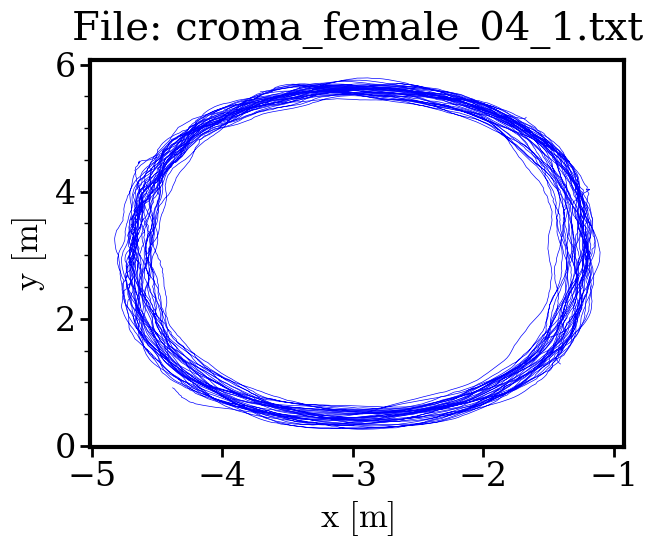

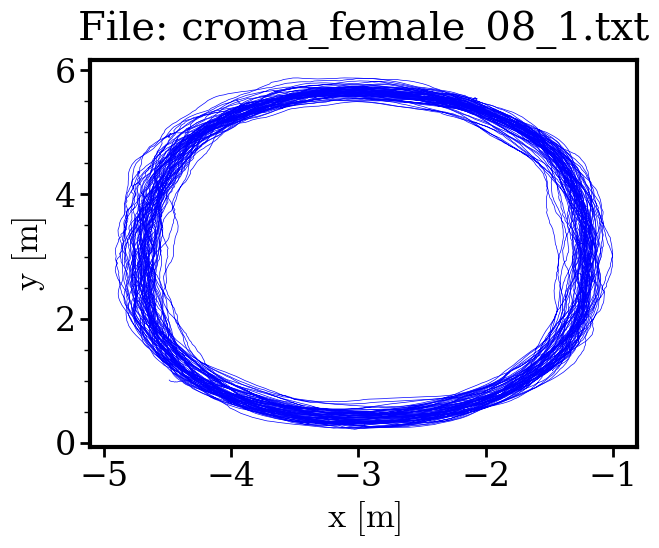

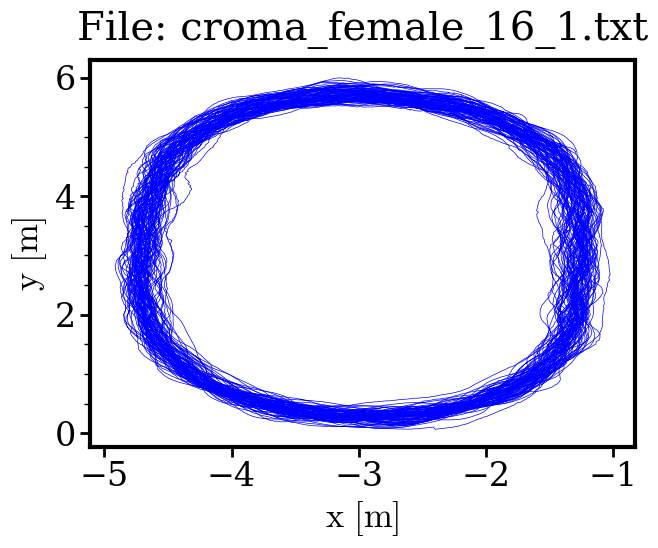

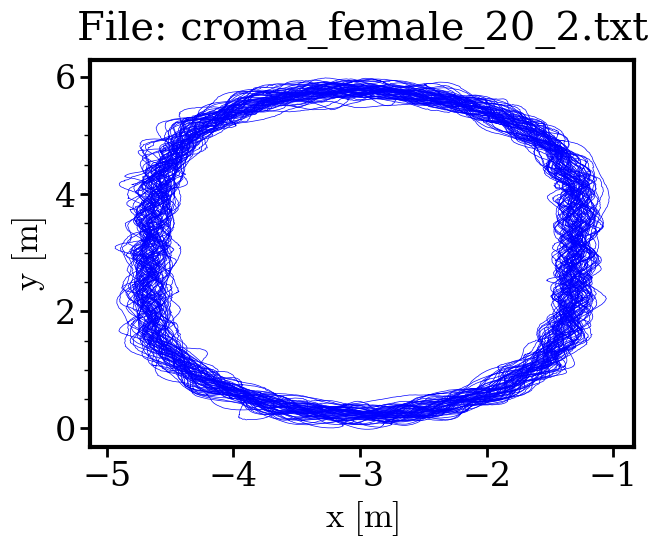

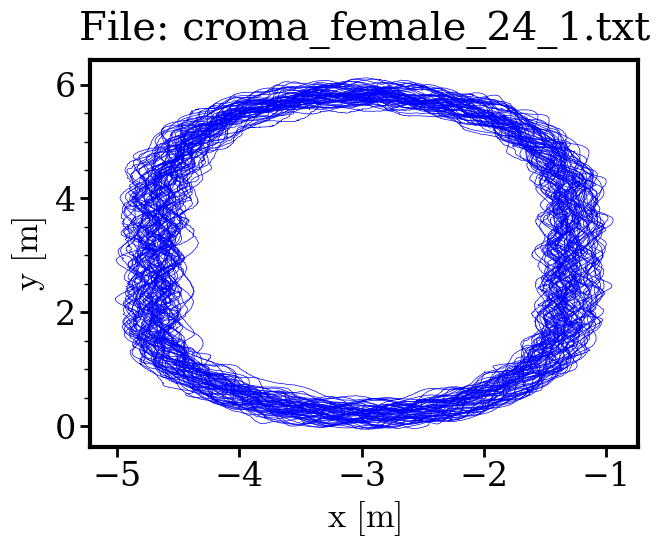

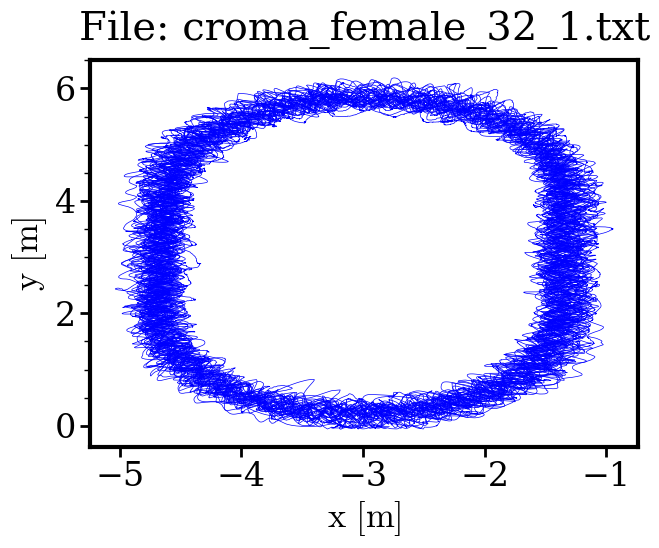

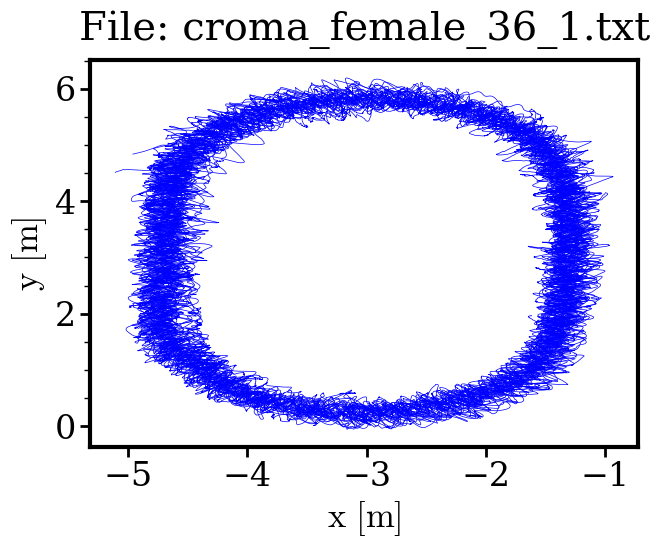

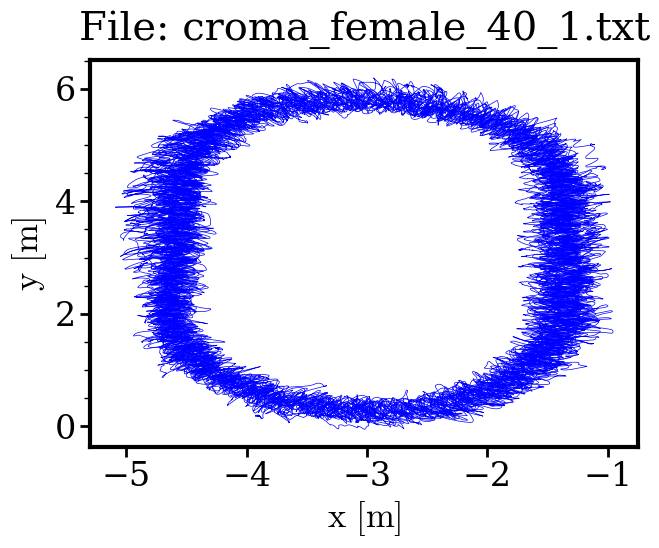

In [67]:
import matplotlib.pyplot as plt
plt.style.use('../helper/plotsettings.mplystyle')

dic_traj_raw={}

for file in files_traj_raw:
    # read the raw trajectories
    data_traj_raw=pd.read_csv(path_traj_raw+"/"+file,
                              comment="#",
                              delimiter=" ",
                              names=["ID","frame","x(m)","y(m)","z(m)","markerID"])

    # save the raw trajectories in a dictionary 
    dic_traj_raw[file]=data_traj_raw
    
    # plot raw trajectories for each pedestrian
    fig = plt.figure(figsize=(7, 6))
    for ID in data_traj_raw["ID"].unique():
        plt.plot(data_traj_raw[data_traj_raw["ID"]==ID]["x(m)"],
                 data_traj_raw[data_traj_raw["ID"]==ID]["y(m)"],
                 "b-",
                 linewidth=0.5)
            
    plt.title(f'File: {file}')
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.tight_layout()
    # plt.savefig(f'raw_traj_{file}.pdf', bbox_inches='tight')
    plt.show()

### Apply the transformation additional

Upon observing the plots of the raw trajectories, we notice that the (x, y) values are centered around (0, 0). Different data files may have varying center points, depending on the trajectory data extraction process.

For our transformation of oval trajectories to straight trajectories, we follow the same method as [Ziemer et al.](http://arxiv.org/abs/1602.03053) (refer to the following Figure). Thus, we need to adjust the trajectories in the new coordinate system, which corresponds to a person starting to walk from the beginning of the bottom straight corridor at x=0 along the middle line of the corridor (y=0). Additionally, the direction of pedestrians' movement should be counterclockwise; if it is clockwise, a horizontal reflection should be applied.

<p align="center">
    <img src="../notebooks/demo_data/new_coordinate_system_ziemer.png">
</p>

First, we need to apply the proper transformation (i.e., rotate, shift). We store the transformation data for the available single-file experiments in the data class [experiments.py](../helper/experiments.py), along with other data required for the analysis.


> **NOTE:** the new transformation data can be saved as an object in the data class [experiments.py](../helper/experiments.py), as the following example:
```py
    "genderCroMa_setupLeft_germany_paetzke": ExperimentData(
        link_data="https://doi.org/10.34735/ped.2021.5",
        delimiter='\t',
        shift_x=-1.7,
        shift_y=-1.3,
        ref_y=-1,
        x_rotate=3,
        y_rotate=2,
        fps=25,
        length=2.3,
        radius=1.65,
        circumference=14.97,
        camera_capture=0
    )
``` 
or choose one of the stored objects:

In [68]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'helper'))+'/')
from experiments import EXPERIMENTS

# the key of the experiment (object from class data) 
exp_key="genderCroMa_setupLeft_germany_paetzke" 
e = EXPERIMENTS[exp_key]

retrieve the following attributes required for the transformation:
- ```min_bound```: min boundary of the straight area (measurement area) (if applicable).
- ```max_bound```: max boundary of the straight area (measurement area) (if applicable).
- ```unit```: 100 if data are in cm. Otherwise 1.

In [69]:
min_bound = e.Min
max_bound = e.Max
unit = e.unit

Now, apply the transformation additional function to modify the trajectory data:

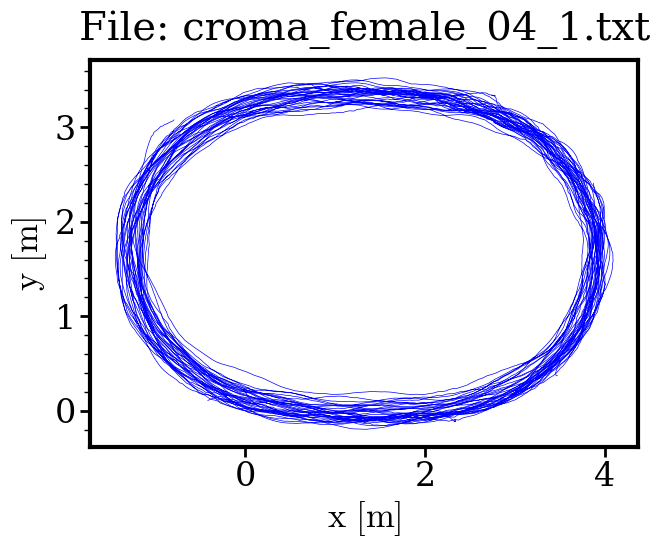

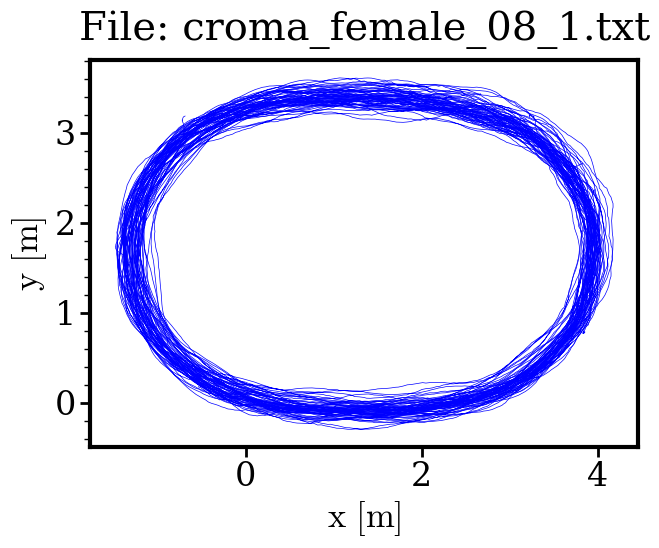

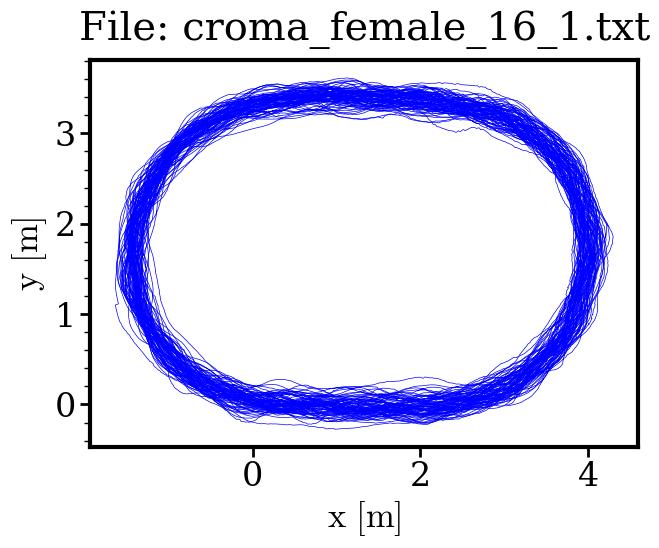

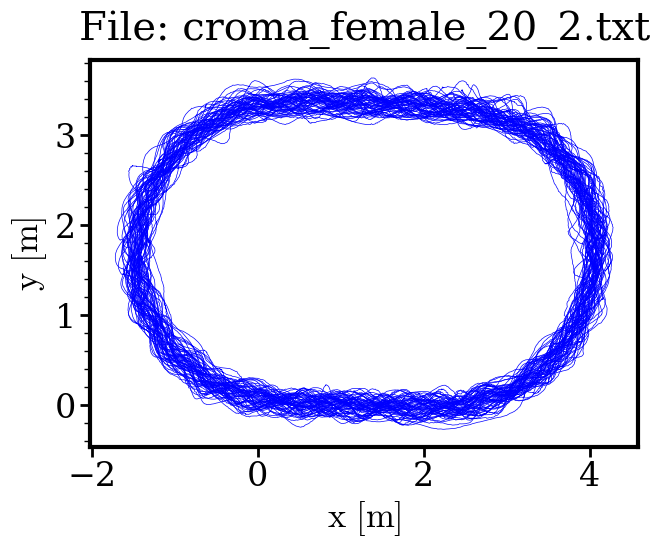

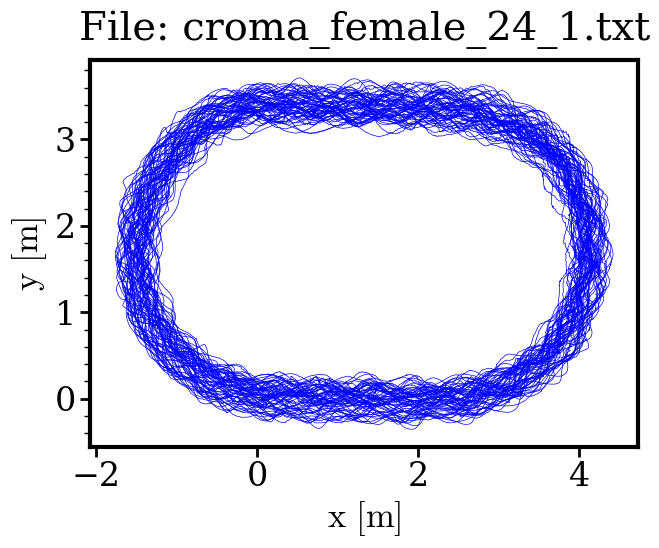

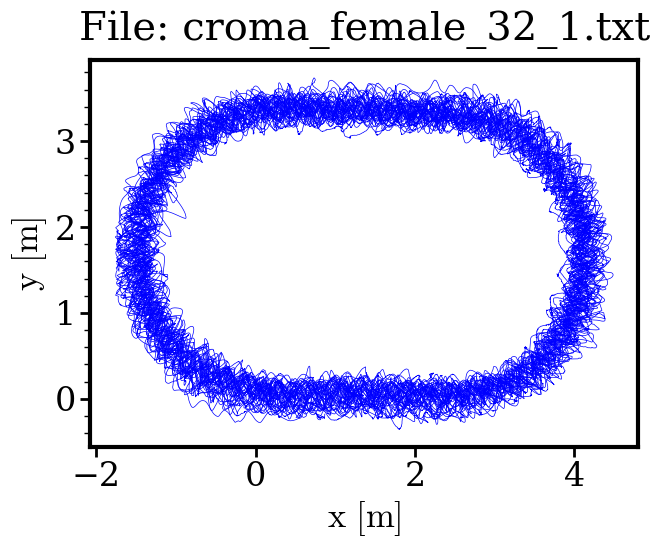

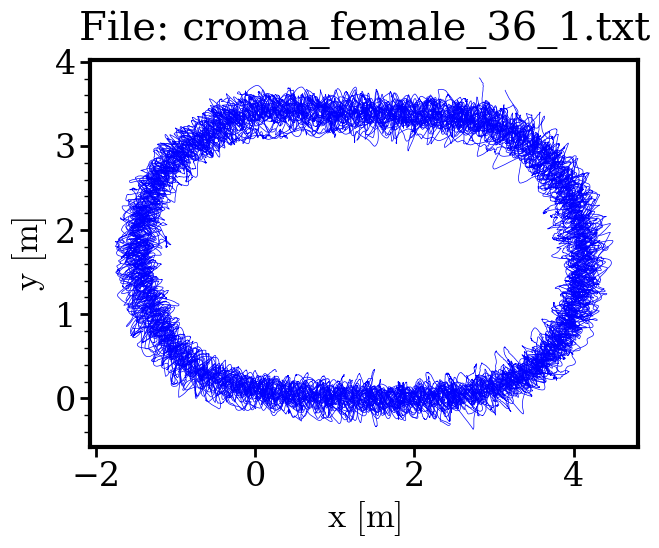

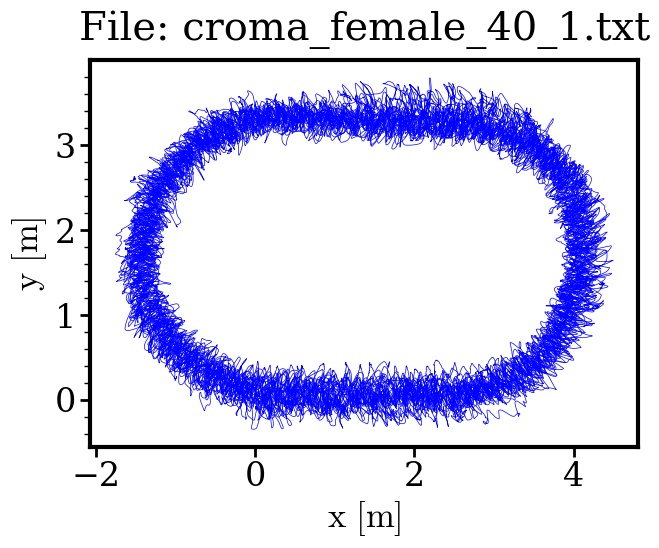

In [70]:
from helper import process_data

dict_transformation_additional= {}

for key in dic_traj_raw.keys():
    data_traj_raw=dic_traj_raw[key]
    x_y_transformed = process_data(data_traj_raw[["x(m)","y(m)"]].to_numpy(), exp_key)
    data_traj_tranformed = data_traj_raw.copy()
    data_traj_tranformed[["x(m)","y(m)"]]=pd.DataFrame(x_y_transformed, columns=["x(m)","y(m)"])

    if (min_bound is not None) and (max_bound is not None):  # data inside measurement area (unique for each experiment)
        data_traj_tranformed = data_traj_tranformed[((data_traj_tranformed['x(m)'] / unit) >= min_bound) & ((data_traj_tranformed['y(m)'] / unit) <= max_bound)]

    dict_transformation_additional[key] = data_traj_tranformed

    # plot the transformed trajectories for each pedestrian
    fig = plt.figure(figsize=(7, 6))
    for ID in data_traj_tranformed["ID"].unique():
        plt.plot(data_traj_tranformed[data_traj_tranformed["ID"]==ID]["x(m)"],
                 data_traj_tranformed[data_traj_tranformed["ID"]==ID]["y(m)"],
                 "b-",
                 linewidth=0.5)
        
    plt.title(f'File: {key}')    
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.tight_layout()
    # plt.savefig(f'trans_additional_{key}.pdf', bbox_inches='tight')
    plt.show()

### Apply the transformation straight to the data

Now, we will convert the oval trajectories to straight trajectories.

First, retrieve the following attributes:
- ```corridor_straight_length```: length of the straight part of the corridor.
- ```corridor_length```: length of the whole corridor (oval circumference).
- ```corridor_radius```: radius of the curved part of the corridor:
- ```fps```: number of frames per second that the camera captures.

In [71]:
corridor_straight_length = e.length
corridor_length = e.circumference
corridor_radius = e.radius
fps=e.fps

Second, we apply the function ``` transformation_coord(...) ``` to transform the coordinates to straight:

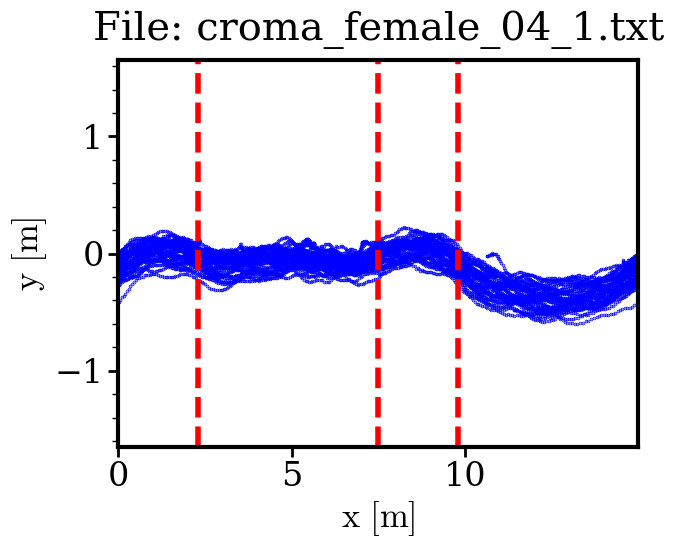

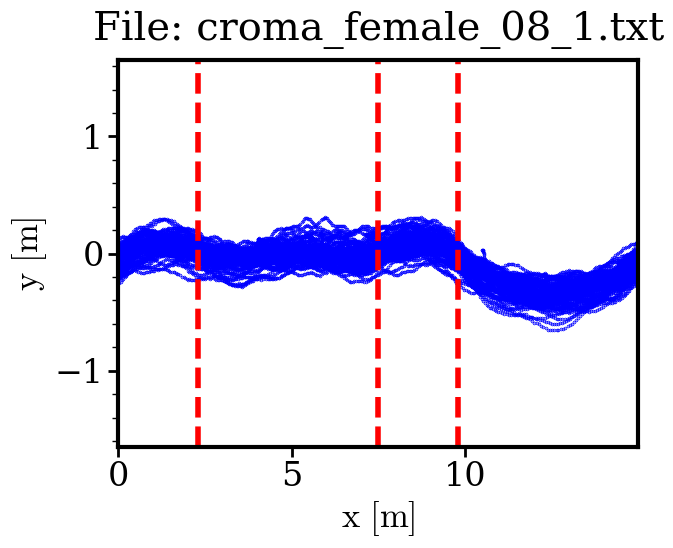

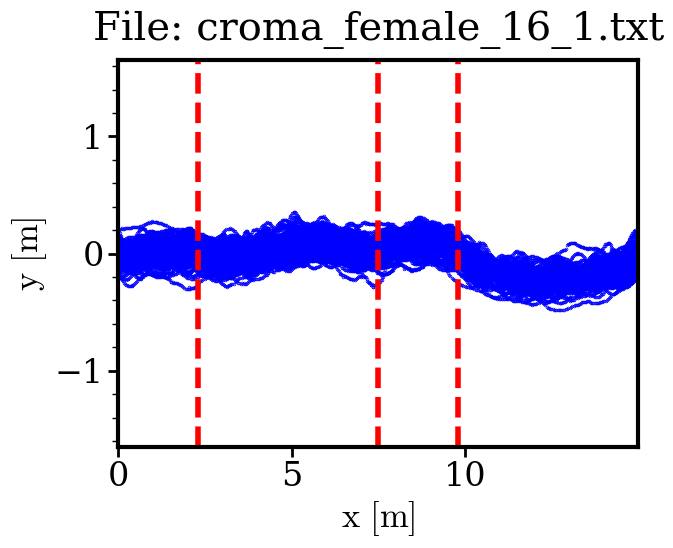

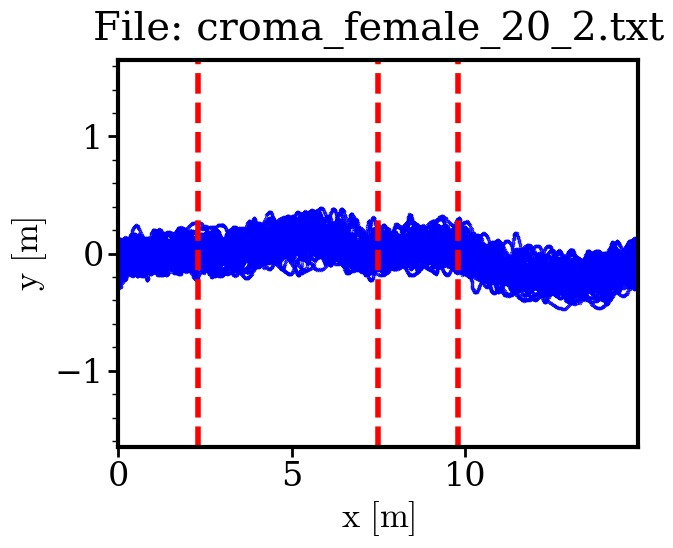

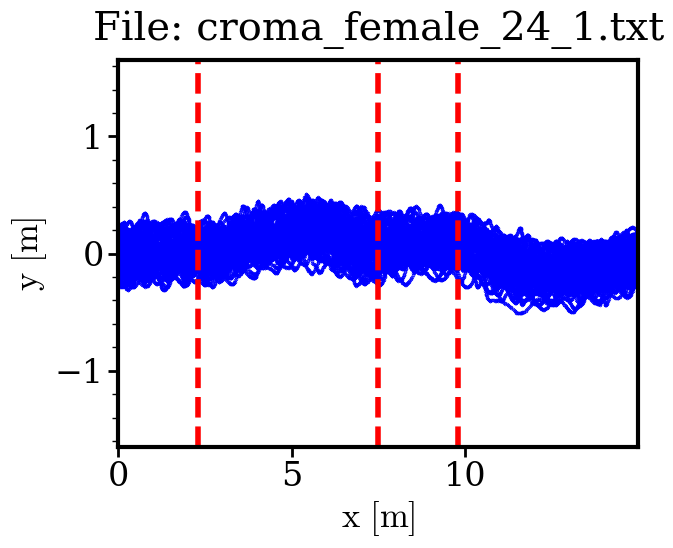

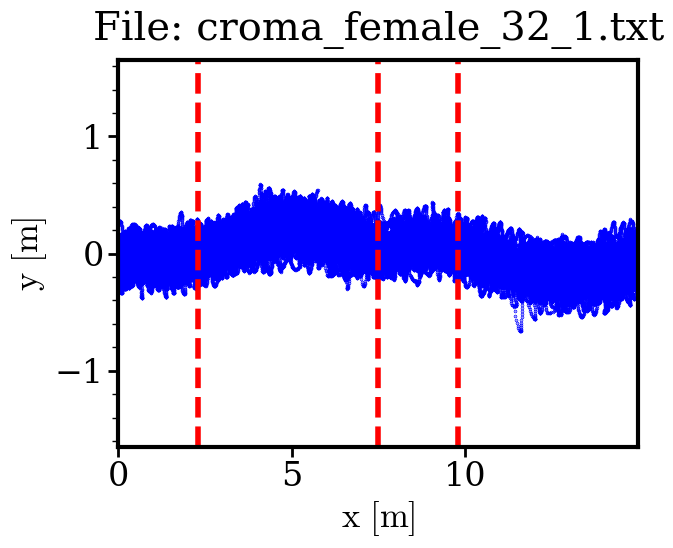

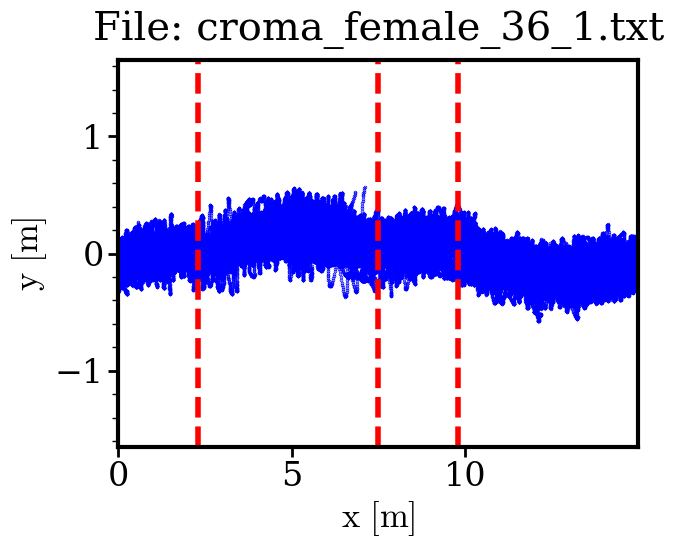

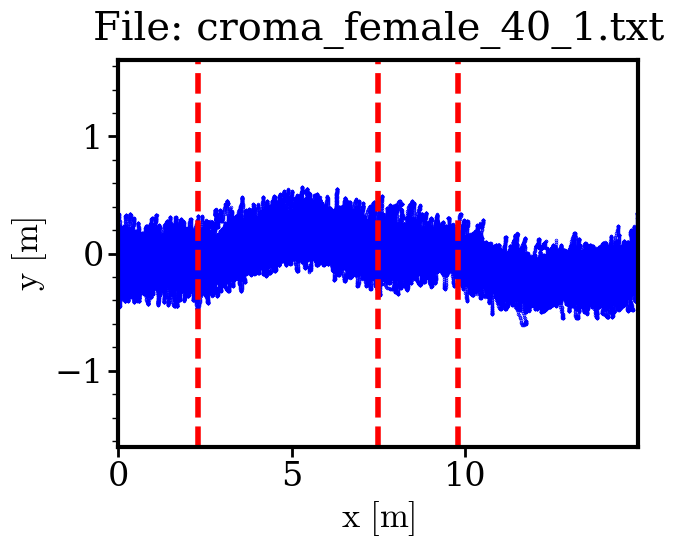

In [72]:
from helper import transformation_coord

dict_transformation_straight = {}

for key in dict_transformation_additional.keys():
    data_transformation_additional = dict_transformation_additional[key]

    x_y_trans = transformation_coord(data_transformation_additional[["x(m)","y(m)"]].to_numpy(),
                                            corridor_straight_length, 
                                            corridor_radius)
    data_transformation_straight=data_transformation_additional.copy()
    data_transformation_straight['x(m)']=x_y_trans[:,0]
    data_transformation_straight['y(m)']=x_y_trans[:,1]
    dict_transformation_straight[key] = data_transformation_straight

    # plot the transformed straight trajectories
    fig = plt.figure(figsize=(7, 6))
    for ID in data_transformation_straight["ID"].unique():
        # Note: each trajectory of pedestrians is plotted for different iteration
        # iteration means the pedestrian walks the all setup track and start again from the beginning (0, half corridor width)
        plt.plot(data_transformation_straight[data_transformation_straight["ID"]==ID]['x(m)'], 
                data_transformation_straight[data_transformation_straight["ID"]==ID]['y(m)'], 
                "bo", 
                markersize=0.5)
    
    plt.title(f'File: {key}')
    plt.xlim(0,corridor_length)
    plt.ylim(-corridor_radius,corridor_radius)
    plt.xlabel(r"$\rm x~[m]$")
    plt.ylabel(r"$\rm y~[m]$")
    plt.vlines(corridor_straight_length, 
               -corridor_radius, 
               corridor_radius, 
               colors='red', 
               linestyles='dashed')
    plt.vlines(corridor_straight_length+(2*np.pi*corridor_radius)/2, 
               -corridor_radius, 
               corridor_radius, 
               colors='red',
               linestyles='dashed')
    plt.vlines(2*corridor_straight_length+(2*np.pi*corridor_radius)/2, 
               -corridor_radius, 
               corridor_radius, 
               colors='red', 
               linestyles='dashed')
    plt.tight_layout()
    # plt.savefig(f'traj_straight_{key}.pdf', bbox_inches='tight')
    plt.show()

> **NOTE:** the dashed red lines indicate the parts of the oval setup (straight, curved, straight, curved).

### Plot the space-time relation

To plot the space-time relation, we need to plot the x-position values from the straight trajectories data of pedestrians as follows:

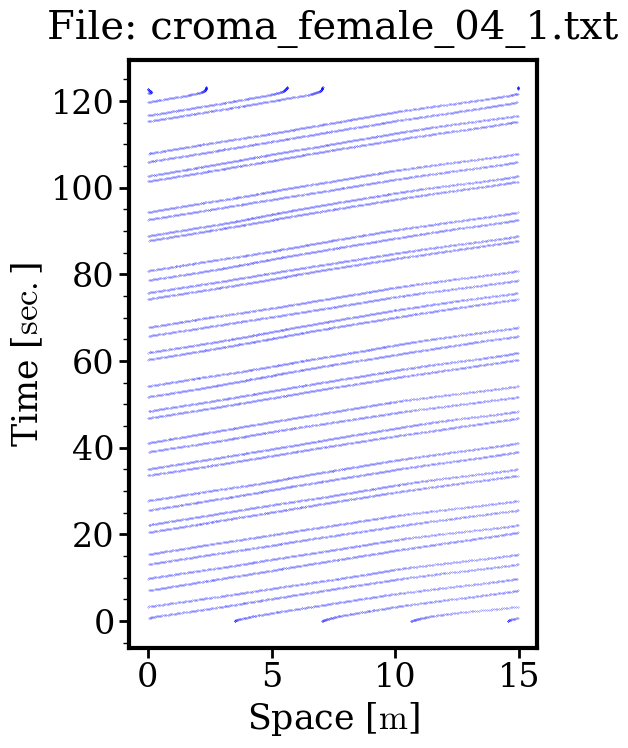

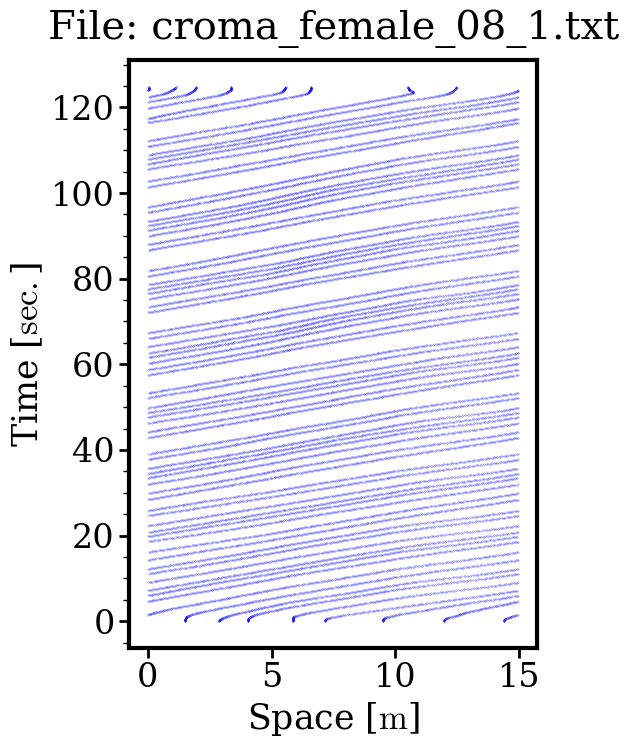

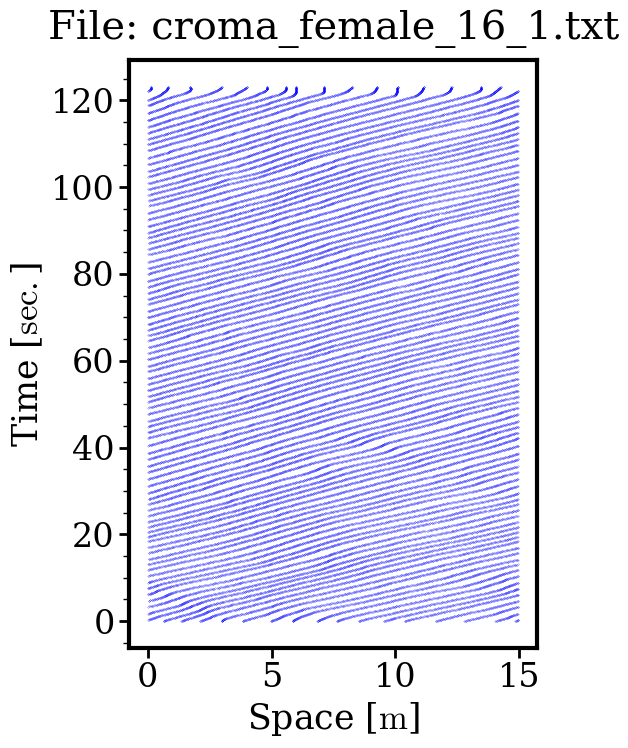

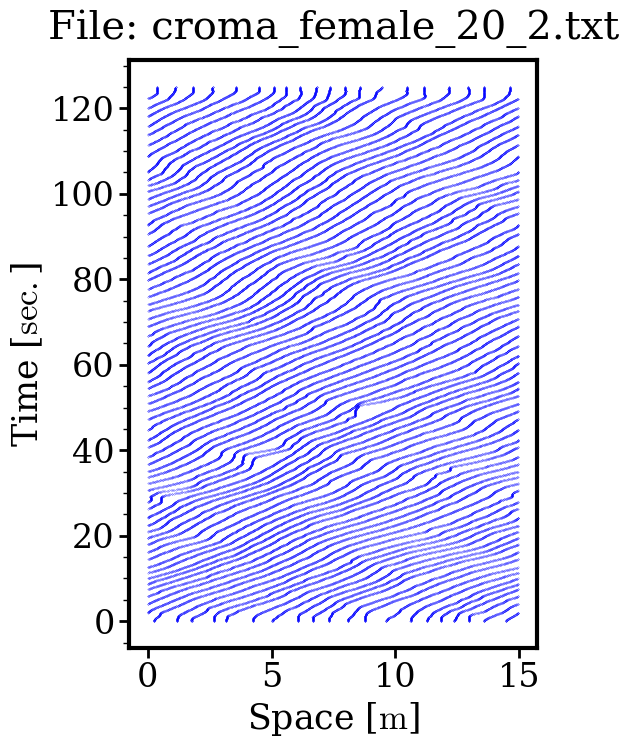

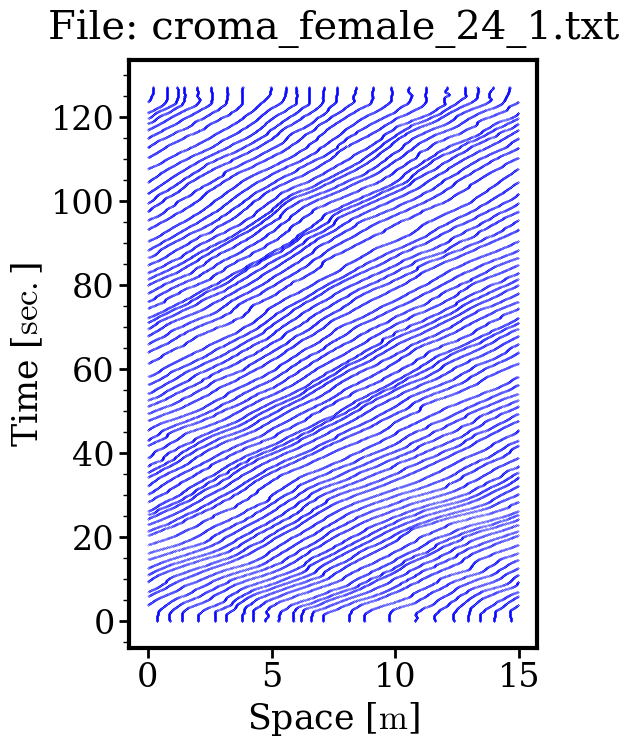

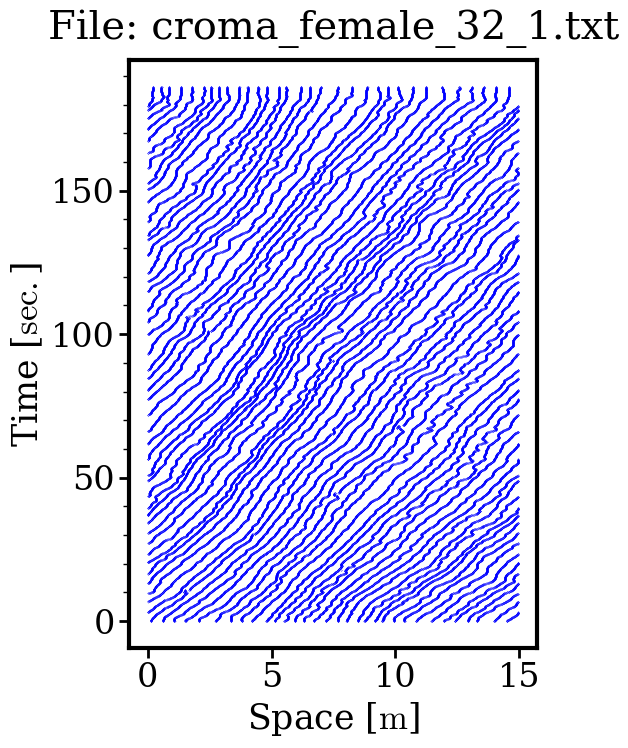

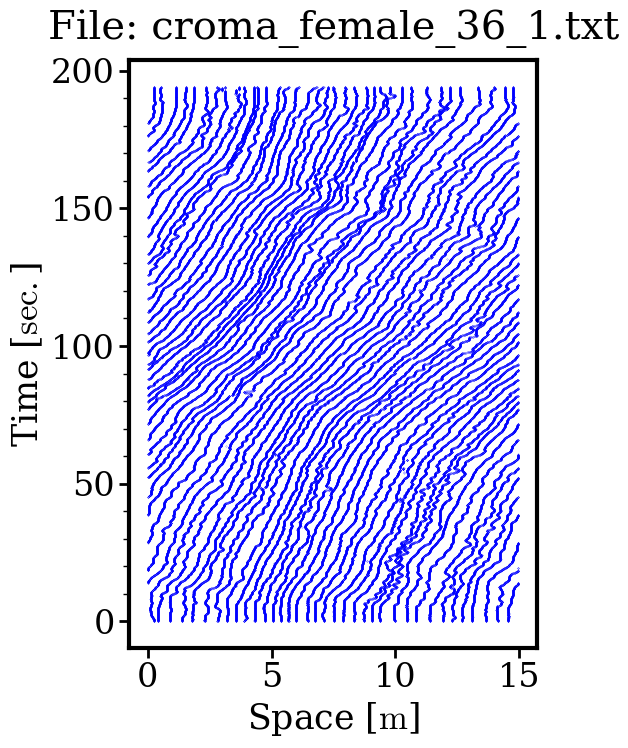

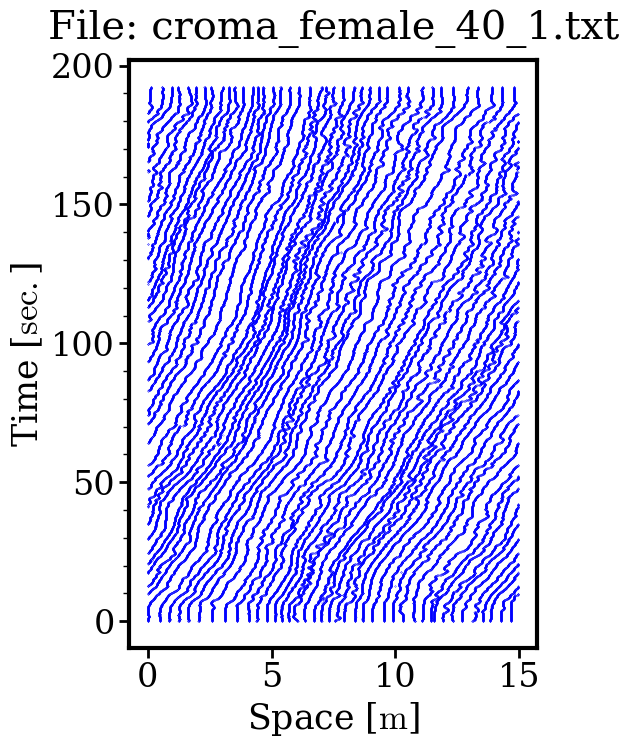

In [73]:
for key in dict_transformation_straight.keys():
    fig = plt.figure(figsize=(6, 8))

    data = dict_transformation_straight[key]

    for ped_id in set(data["ID"]):
        # Take only the trajectory for one person
        # Note: each trajectory of pedestrians is plotted for different iteration
        # iteration means the pedestrian walks the all setup track and start again from the beginning (0, half corridor width)
        p_data = data.loc[data["ID"] == ped_id]
        plt.scatter(p_data["x(m)"], 
                    p_data["frame"] / fps, 
                    s=0.1, 
                    edgecolors="blue", 
                    facecolors="blue", 
                    marker=".")

    plt.title(f"File: {key}")
    plt.xlabel(r"Space [$\rm m$]")
    plt.ylabel(r"Time [$\rm sec.$]")
    plt.tight_layout()
    plt.show()


### Calculate the speed and density of the pedestrians

Here we calculate the individual instantaneous speed and the 1D Voronoi density for each pedestrian over time frames.

First, we define the arguments required for the calculations:
- ```camera_capture```: top-view, or side-view camera.
- ```delta_t```: the time constant to calculate the speed.

In [74]:
camera_capture = e.camera_capture
delta_t=0.4

then, we apply the function  ```calculate_speed_density_headway(...)``` to calculate the speed, density, and headway of each pedestrian:
1. Speed using the displacement horizantal ```flag_disp='x'```
1. Speed using the displacement Euclidean distance ```flag_disp='r'```

In [75]:
from helper import calculate_speed_density_headway

dic_speed_density_headway = {}

for key in dict_transformation_straight.keys():
    data = dict_transformation_straight[key]
    new_data = np.array(data[['ID','frame','x(m)','y(m)','z(m)']])
    result = calculate_speed_density_headway(new_data,
                                             fps,
                                             corridor_length,
                                             camera_capture,
                                             delta_t,
                                             flag_disp = 'x')
    data_speed_density_headway = pd.DataFrame(result,columns=['ID','frame','x(m)','y(m)','z(m)','speed(m/s)','headway(s)','density(1/m)'])

    dic_speed_density_headway[key] = data_speed_density_headway


### Choose the steady state

In the single-file movement experiments, pedestrian movement can be categorized into three states: transit states at the beginning and end of the experiment, where pedestrians increase and decrease their speed over time, respectively, and a steady state where pedestrians' speed remains stable over time.

In this step, we need to select the time instances for the steady state to then plot the relations, such as density-speed and headway-speed.


> **NOTE:** Skip the 'Choose the steady state' section if you intend to apply the analysis to all states of pedestrian movement.

First, plot the time-speed/density relation:

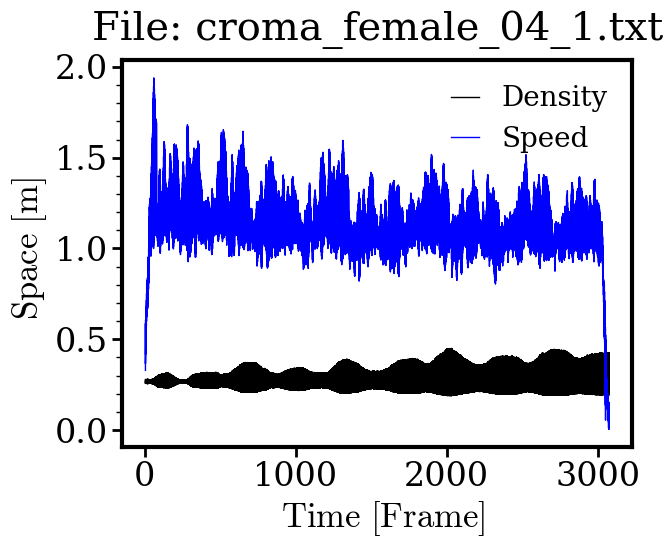

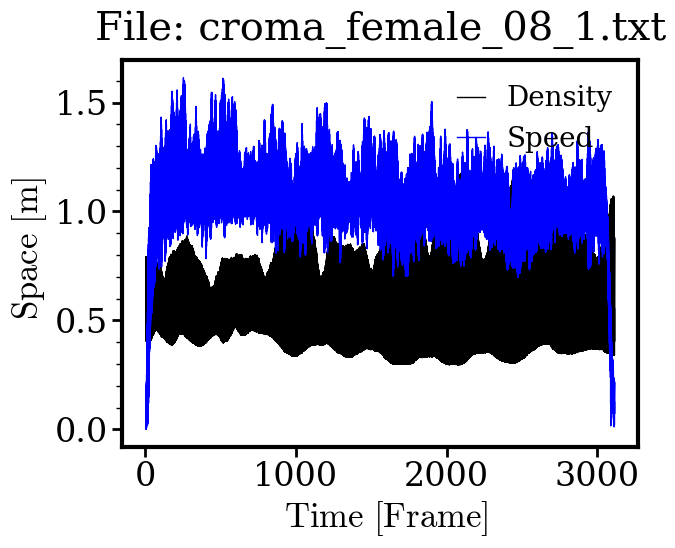

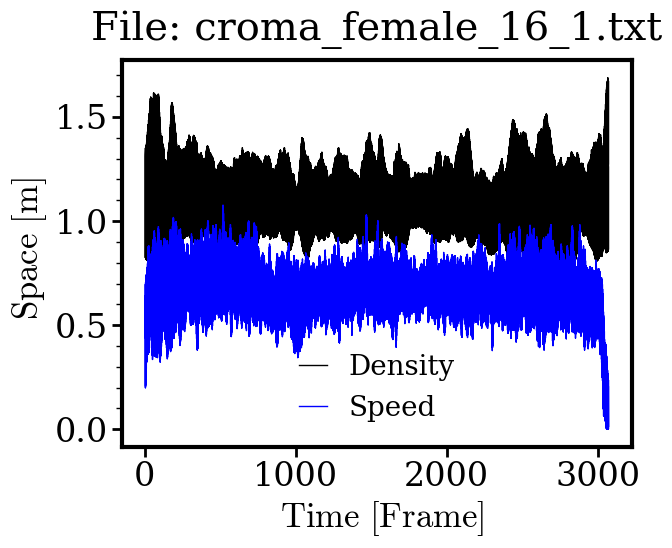

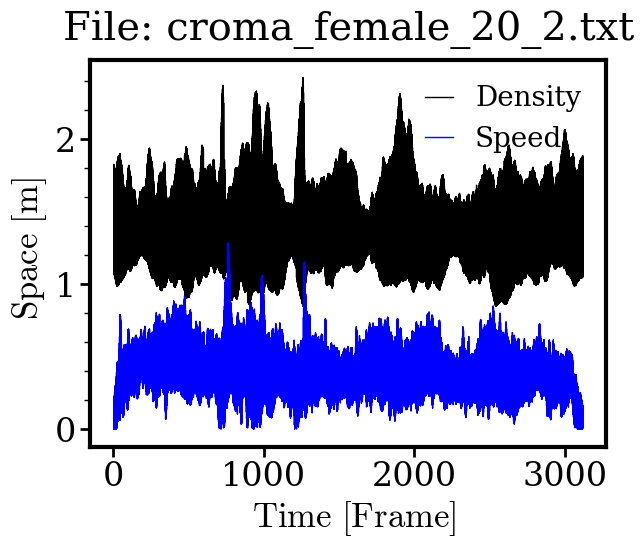

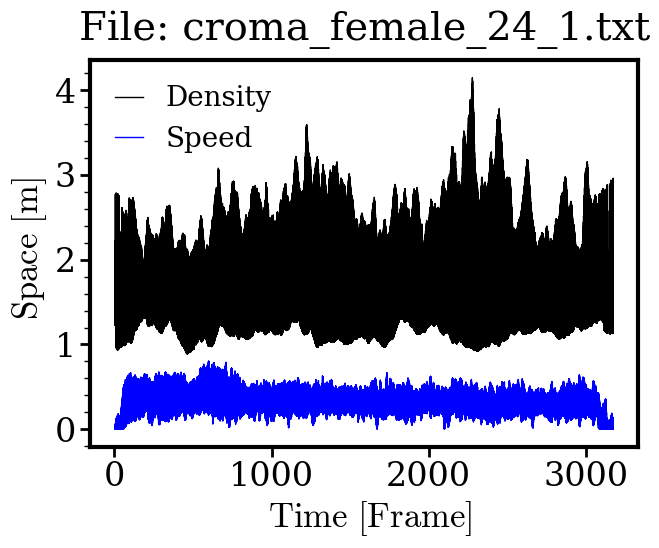

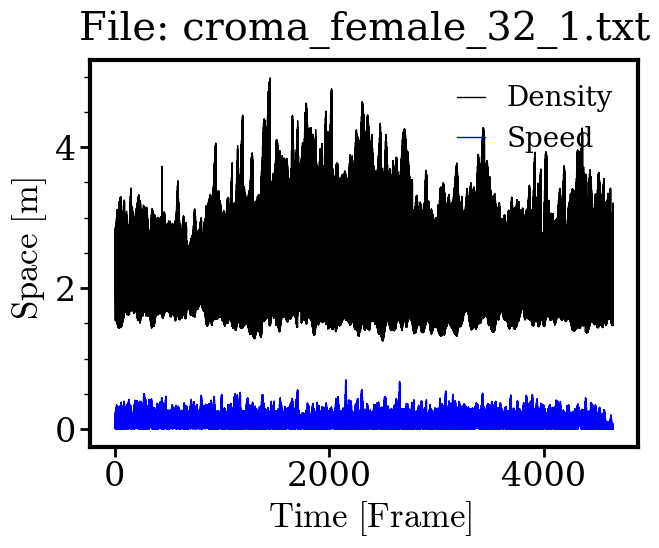

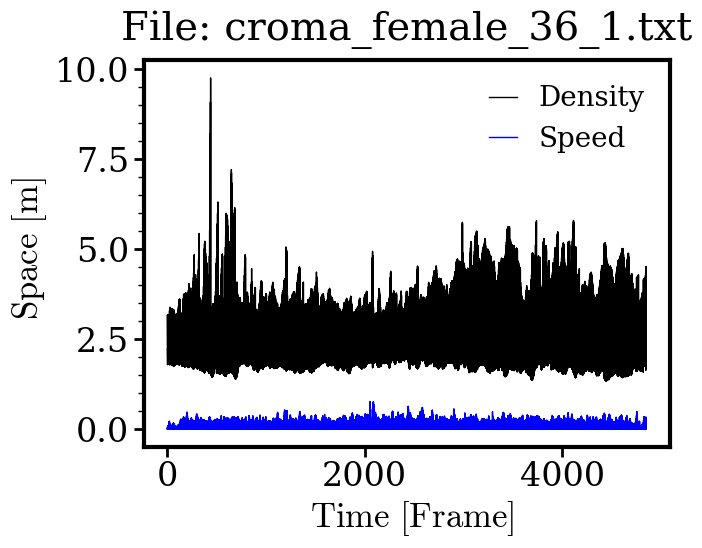

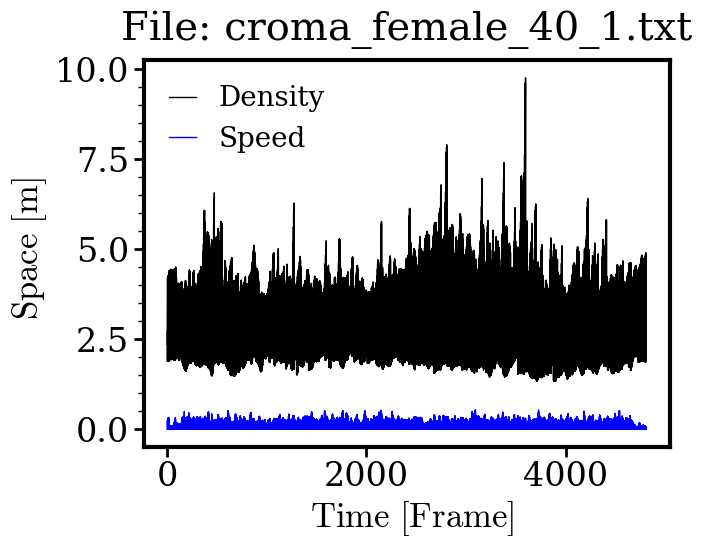

In [76]:

for key in dic_speed_density_headway.keys():
    rho_vel_head_data = dic_speed_density_headway[key]

    fig = plt.figure(figsize=(7, 6))
    plt.plot(rho_vel_head_data['frame'], 
            rho_vel_head_data['density(1/m)'], 
            'k-', 
            label="Density",
            linewidth=1)
    plt.plot(rho_vel_head_data['frame'], 
            rho_vel_head_data['speed(m/s)'], 
            'b-', 
            label="Speed",
            linewidth=1)

    plt.title(f'File: {key}')
    plt.xlabel(r" $\rm Time~[Frame]$")
    plt.ylabel(r" $\rm Space~[m]$")
    plt.legend()
    plt.tight_layout()
    plt.show()

let's use the experiment file "female_05_01.csv" to manually select the start and end frames of the steady state:

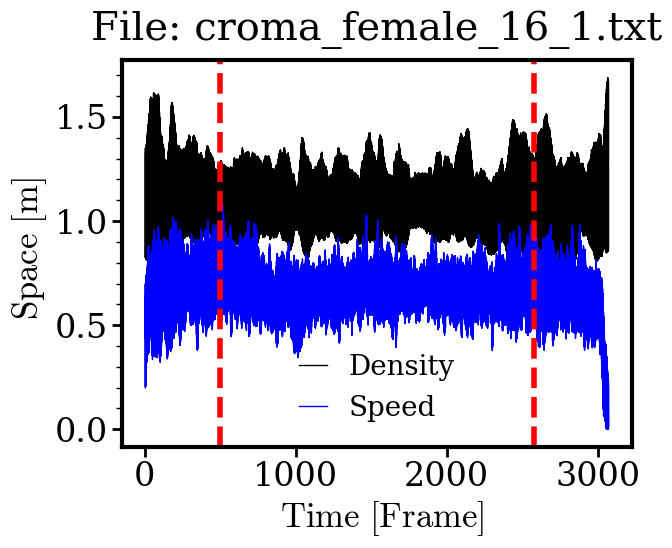

In [89]:
key="croma_female_04_1.txt"
st = 1500 # start time frame of the steady state
en = 2900 # end time frame of the steady state

steady_state_data = dic_speed_density_headway[key]

fig = plt.figure(figsize=(7, 6))
plt.plot(steady_state_data['frame'], 
         steady_state_data['density(1/m)'], 
         'k-', 
         label="Density",
         linewidth=1)
plt.plot(steady_state_data['frame'], 
         steady_state_data['speed(m/s)'], 
         'b-', 
         label="Speed",
         linewidth=1)

plt.axvline(x=st, 
            linestyle="--", 
            color='red')
plt.axvline(x=en, 
            linestyle="--", 
            color='red')

plt.title(f'File: {key}')
plt.xlabel(r" $\rm Time~[Frame]$")
plt.ylabel(r" $\rm Space~[m]$")
plt.legend()
plt.tight_layout()
plt.show()

save the start and end frames of all experiments' steady states in the following argument:

In [78]:
# flag_disp='x'
starts=[1500,1500,500,1500,600,2600,1000,600]
ends=[2900,3000,2580,2590,2000,4500,2990,2300]

# # flag_disp='r'
# starts=[1000,100,1000,0,0,0,2000,1500]
# ends=[2000,3000,3000,3000,3000,4000,4000,2500]

extract the data corresponding to the steady state from all the experiments' data:

In [79]:
from helper import extract_steady_state

dic_speed_density_headway_steady_state = {}

for key, start, end in zip(dic_speed_density_headway.keys(), starts, ends):
    steady_state_data = extract_steady_state(dic_speed_density_headway[key].to_numpy(), 
                                  start, 
                                  end)
    dic_speed_density_headway_steady_state[key] = pd.DataFrame(steady_state_data, 
                                                               columns=['ID','frame','x(m)','y(m)','t(s)','speed(m/s)','headway(s)','density(1/m)'])

### Plot the fundamental diagram (density-speed)

Plot the fundamental diagram relation (density-speed), customizing the figure labels and adding the experiment name as the figure title:

In [80]:
labels = ['Female=4', 
          'Female=8', 
          'Female=16', 
          'Female=20', 
          'Female=24', 
          'Female=32', 
          'Female=36', 
          'Female=40']
experiment_name="Paetzke2023"

then, plot:

(57748, 8)


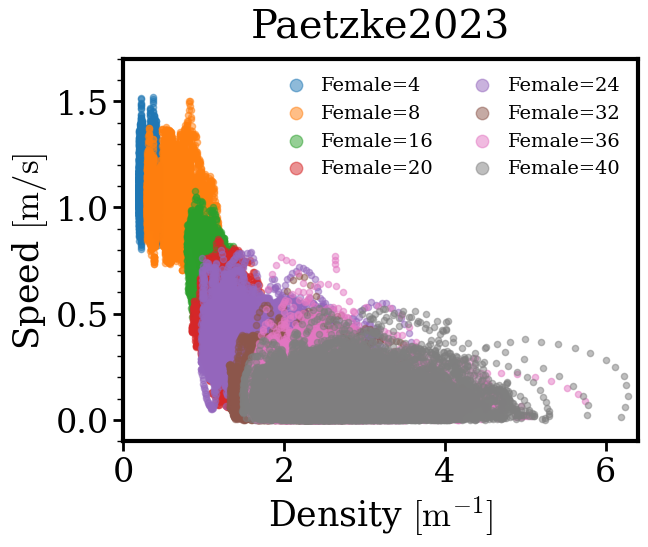

In [81]:
fig = plt.figure(figsize=(7, 6))

for key,label in zip(dic_speed_density_headway_steady_state.keys(),labels):
    data = dic_speed_density_headway_steady_state[key]
    # data = data.sample(frac=np.minimum(.12,32469/data.shape[0])) # 12% of the total data
    plt.scatter(data["density(1/m)"], 
                data["speed(m/s)"], 
                label=label, 
                alpha=0.5,
                s=20)

plt.xlabel(r"Density $\rm [m^{-1}]$")
plt.ylabel(r"Speed $\rm [m/s]$")
print(data.shape)
plt.legend(ncol=2, fontsize=14)
plt.title(f"{experiment_name}")
plt.xlim(0,6.4)
plt.ylim(-0.10,1.7)
plt.tight_layout()
# plt.savefig(f'speed_density_{experiment_name}.pdf', bbox_inches='tight')
# plt.savefig(f'speed_density_{experiment_name}.png', bbox_inches='tight')
plt.show()


### Plot the headway-speed relation

and to plot the headway-speed relations:

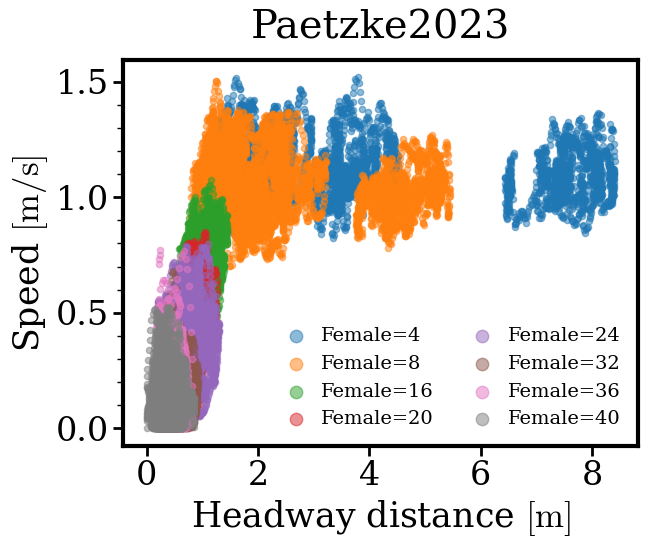

In [90]:
fig = plt.figure(figsize=(7, 6))

for key,label in zip(dic_speed_density_headway_steady_state.keys(),labels):
    data = dic_speed_density_headway_steady_state[key]
    # data = data.sample(frac=np.minimum(.12,32469/data.shape[0])) # 12% of the total data
    plt.scatter(data["headway(s)"], 
                data["speed(m/s)"], 
                label=label, 
                alpha=0.5,
                s=20)

plt.xlabel(r"Headway distance $\rm [m]$")
plt.ylabel(r"Speed $\rm[m/s]$")
plt.legend(ncol=2, fontsize=14)
plt.title(f"{experiment_name}")
plt.tight_layout()
# plt.savefig(f'palestine_headway_speed_{delta_t}_FD.pdf', bbox_inches='tight')
plt.show()

### Save the data into files

Here are the codes to save all results in .csv files for the following:
- Trajectory transformation additional data
- Trajectory transformation straight data
- Density, speed, and headway data

First, choose the path of the directory to save the outputs:

In [83]:
path_output="../notebooks/demo_data/genderFemale_germany_paetzke2023"

Then, save the data of transformation additional:

In [84]:
for key in dict_transformation_additional.keys():
    data = dict_transformation_additional[key]
    if not os.path.exists(path_output+"/traj/02_transformation_additional/"):
        os.makedirs(path_output+"/traj/02_transformation_additional/")
    data.to_csv(path_output+"/traj/02_transformation_additional/"+key, 
                sep='\t',
                index=False)

save the data of transformation straight:

In [85]:
for key in dict_transformation_straight.keys():
    data = dict_transformation_straight[key]
    if not os.path.exists(path_output+"/traj/03_transformation_straight/"):
        os.makedirs(path_output+"/traj/03_transformation_straight/")
    data.to_csv(path_output+"/traj/03_transformation_straight/"+key, 
                sep='\t',
                index=False)

save the caclulated movement quantities (density,speed, headway):

In [86]:
for key in dic_speed_density_headway.keys():
    data = dic_speed_density_headway[key]
    if not os.path.exists(path_output+"/rho_vel_headway/"):
        os.makedirs(path_output+"/rho_vel_headway/")
    data.to_csv(path_output+"/rho_vel_headway/"+key, 
                sep='\t',
                index=False)

save the caclulated movement quantities (density,speed, headway) in the 
steady state:

In [87]:
for key in dic_speed_density_headway_steady_state.keys():
    data = dic_speed_density_headway_steady_state[key]
    if not os.path.exists(path_output+"/rho_vel_headway/steady_state_data/"):
        os.makedirs(path_output+"/rho_vel_headway/steady_state_data/")
    data.to_csv(path_output+"/rho_vel_headway/steady_state_data/"+key, 
                sep='\t',
                index=False)